In [ ]:
pip install pandas

In [ ]:
!pip uninstall numpy

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2


In [ ]:
pip install numpy

In [ ]:
pip install simglucose

In [ ]:
pip install -e


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime

AttributeError: ignored

In [ ]:
from datetime import timedelta
from datetime import time as dt_time
from datetime import datetime

import numpy as np
import pandas as pd



In [ ]:
# specify start_time as the beginning of today
now = datetime.now()
t0 = datetime.combine(now.date(), dt_time(6, 0, 0, 0))
start_time=t0
#start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

df=pd.read_csv('vpatient_params.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from simglucose.simulation.scenario import Action, Scenario
import numpy as np
from scipy.stats import truncnorm
from datetime import datetime
import logging

logger = logging.getLogger(__name__)


class BatchRandomScenario(Scenario):
    def __init__(self, start_time, seed=None):
        Scenario.__init__(self, start_time=start_time)
        self.seed = seed

    def get_action(self, t):
        # t must be datetime.datetime object
        delta_t = t - datetime.combine(t.date(), datetime.min.time())
        t_sec = delta_t.total_seconds()

        if t_sec < 1:
            logger.info('Creating new one day scenario ...')
            self.scenario = self.create_scenario()

        t_min = np.floor(t_sec / 60.0)

        if t_min in self.scenario['meal']['time']:
            logger.info('Time for meal!')
            idx = self.scenario['meal']['time'].index(t_min)
            return Action(meal=self.scenario['meal']['amount'][idx])
        else:
            return Action(meal=0)

    def create_scenario(self):
        scenario = {'meal': {'time': [], 'amount': []}}

        # Probability of taking each meal
        # [breakfast, snack1, lunch, snack2, dinner, snack3]
        prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
        time_lb = np.array([5, 9, 10, 14, 16, 20]) * 60
        time_ub = np.array([9, 10, 14, 16, 20, 23]) * 60
        time_mu = np.array([7, 9.5, 12, 15, 18, 21.5]) * 60
        time_sigma = np.array([60, 30, 60, 30, 60, 30])
        amount_mu = [10, 3, 20, 3, 20, 3]
        amount_sigma = [3, 1, 3, 1, 3, 1]

        for p, tlb, tub, tbar, tsd, mbar, msd in zip(prob, time_lb, time_ub,
                                                     time_mu, time_sigma,
                                                     amount_mu, amount_sigma):
            if self.random_gen.rand() < p:
                tmeal = np.round(
                    truncnorm.rvs(a=(tlb - tbar) / tsd,
                                  b=(tub - tbar) / tsd,
                                  loc=tbar,
                                  scale=tsd,
                                  random_state=self.random_gen))
                scenario['meal']['time'].append(tmeal)
                scenario['meal']['amount'].append(
                    max(round(self.random_gen.normal(mbar, msd)), 0))

        return scenario

    def reset(self):
        self.random_gen = np.random.RandomState(self.seed)
        self.scenario = self.create_scenario()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()



In [ ]:
##################################################################################################################
# 1. Setup patient loading its parameters from file
##################################################################################################################
# Create a patient
patient = T1DPatient.withName('adolescent#002')
#add random variation to the Vg value to simulate more patients
patient._params.Vmx=patient._params.Vmx#+0.003*np.random.randn()

In [ ]:
##################################################################################################################
# 2. Setup CGM sensor and pump models
##################################################################################################################
# Creat sensor and insulin pump
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')


In [ ]:
##################################################################################################################
# 3. Setup custom meal pattern
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
max_days=5
prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
base_t=[7, 10, 12.5, 16, 20, 22]
base_m = [10, 3, 20, 3, 20, 3]
sigma_m = [2, 1, 3, 1, 3, 1]
#base_t=[7,12,14,18,22]
#base_m=[45,70,15,80,10]
#base_m=[15,20,3,26,3]
scen=[]

for d in range(max_days):
    for i in range(6):
        pmeal=np.random.uniform()
        if(pmeal<prob[i]):
            tm=(base_t[i]+(np.random.uniform()-0.5)*2)*60+d*24*60
            vm=max(0,base_m[i]+sigma_m[i]*np.random.randn())
            scen.append((tm,vm))

#scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10), (7+24, 45), (12+24, 70), (16+24, 15), (18+24, 80), (23+24, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

In [ ]:
scenario

In [ ]:
##################################################################################################################
# 3. Setup custom meal pattern
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
max_days=5

from simglucose.simulation.scenario_gen import RandomScenario
sim_time = timedelta(days=max_days)
now = datetime.now()

#scenario=RandomScenario(start_time=t0, seed=42)
scenario=BatchRandomScenario(start_time=t0, seed=42)
#m = []
#T = []
#
#t = t0
#while t < t0 + sim_time:
#    action = scenario.get_action(t)
#    m.append(action.meal)
#    T.append(t)
#    t += timedelta(minutes=1)

In [ ]:
np.array(scenario.scenario['meal']['time'])/60

array([ 8.48333333,  9.18333333, 13.03333333, 15.81666667, 17.25      ])

In [ ]:
scenario.scenario

{'meal': {'time': [399.0, 590.0, 692.0, 1100.0, 1307.0],
  'amount': [13, 1, 23, 20, 4]}}

Process ID: 1784
Simulation starts ...
Simulation Completed!


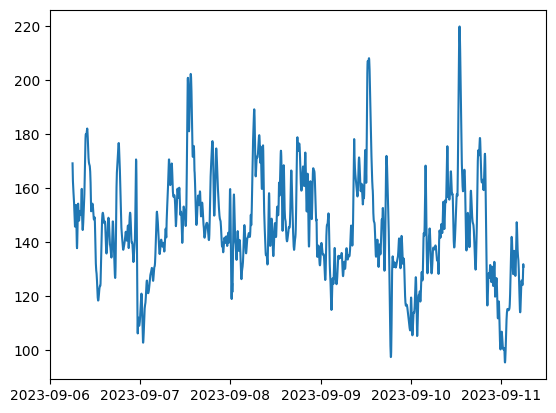

In [ ]:
##################################################################################################################
# 4. Simulate the CGM measures
##################################################################################################################

env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=max_days), animate=False, path=path)
results2 = sim(s2)

import matplotlib.pyplot as plt
plt.plot(results2.CGM)

In [ ]:
results2.CGM

Time
2023-09-06 06:00:00    169.183949
2023-09-06 06:03:00    164.972022
2023-09-06 06:06:00    162.629373
2023-09-06 06:09:00    160.862710
2023-09-06 06:12:00    159.498950
                          ...    
2023-09-11 05:48:00    124.779335
2023-09-11 05:51:00    126.486855
2023-09-11 05:54:00    129.479242
2023-09-11 05:57:00    131.824254
2023-09-11 06:00:00    130.869315
Name: CGM, Length: 2401, dtype: float64

In [ ]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime

# specify start_time as the beginning of today
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
scenario = RandomScenario(start_time=start_time, seed=1)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s1 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results1 = sim(s1)
print(results1)

# --------- Create Custom Scenario --------------
# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
# custom scenario is a list of tuples (time, meal_size)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results2 = sim(s2)
print(results2)


# --------- batch simulation --------------
# Re-initialize simulation objects
s1.reset()
s2.reset()

# create a list of SimObj, and call batch_sim
s = [s1, s2]
results = batch_sim(s, parallel=True)
print(results)

Process ID: 156
Simulation starts ...
Simulation Completed!
                             BG         CGM  CHO   insulin      LBGI  \
Time                                                                   
2023-08-27 00:00:00  149.020000  165.793949  0.0  0.013933  0.000000   
2023-08-27 00:03:00  149.020000  161.582022  0.0  0.013933  0.000000   
2023-08-27 00:06:00  149.020000  159.239373  0.0  0.013933  0.000000   
2023-08-27 00:09:00  149.020000  157.472710  0.0  0.013933  0.000000   
2023-08-27 00:12:00  149.020000  156.108950  0.0  0.013933  0.000000   
...                         ...         ...  ...       ...       ...   
2023-08-27 23:48:00   87.199860   87.566737  0.0  0.013933  2.246258   
2023-08-27 23:51:00   87.154267   86.821155  0.0  0.013933  2.255463   
2023-08-27 23:54:00   87.129784   86.310303  0.0  0.013933  2.260416   
2023-08-27 23:57:00   87.124878   86.138067  0.0  0.013933  2.261409   
2023-08-28 00:00:00   87.137070   86.298608  NaN       NaN  2.258941   

   

In [ ]:
results2

,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
Time,,,,,,,
2023-09-06 06:00:00,152.410000,169.183949,0.0,0.0153,0.0,3.215327,3.215327
2023-09-06 06:03:00,152.410000,164.972022,0.0,0.0153,0.0,3.215327,3.215327
2023-09-06 06:06:00,152.410000,162.629373,0.0,0.0153,0.0,3.215327,3.215327
2023-09-06 06:09:00,152.410000,160.862710,0.0,0.0153,0.0,3.215327,3.215327
2023-09-06 06:12:00,152.410000,159.498950,0.0,0.0153,0.0,3.215327,3.215327
...,...,...,...,...,...,...,...
2023-09-11 05:48:00,136.220550,124.779335,0.0,0.0153,0.0,1.273483,1.273483
2023-09-11 05:51:00,136.443552,126.486855,0.0,0.0153,0.0,1.295406,1.295406
2023-09-11 05:54:00,136.664169,129.479242,0.0,0.0153,0.0,1.317243,1.317243


In [ ]:
'{:s}_{:02d}'.format(patient.name,11)

'adolescent#002_11'

In [ ]:
vpatient_params.values

array([['adolescent#001', 1, 0, ..., 93.2258828462, 11.5048231338, 0],
       ['adolescent#002', 2, 0, ..., 47.1721248798, 4.19657924407, 0],
       ['adolescent#003', 3, 0, ..., 81.3429092974, 6.58878876028, 0],
       ...,
       ['child#008', 88, 0, ..., 119.914029849, 5.46619598839, 0],
       ['child#009', 89, 0, ..., 31.539253961, 8.92304270886, 0],
       ['child#010', 100, 0, ..., 54.4625955612, 4.82258449688, 0]],
      dtype=object)

In [ ]:
print(cgm_data.shape)
print(vpatient_params.values.shape)


(61, 8)
(30, 62)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load target parameter data

vpatient_params=pd.read_csv('vpatient_params.csv')
cgm_data = pd.read_csv('adolescent#002.csv')


# Load your CGM, bolus, meal data (assuming they are already loaded)
# For demonstration, let's assume you've loaded them into 'cgm_data', 'bolus_data', and 'meal_data'

# Combine input data
input_data = cgm_data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cgm_data , vpatient_params.values, test_size=0.2, random_state=42)

# Standardize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define a neural network model
class ParameterEstimationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParameterEstimationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
input_size = X_train_scaled.shape[1]
hidden_size = 128
output_size = target_params.shape[1]  # Adjust based on the number of target parameters
model = ParameterEstimationModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, torch.tensor(y_test, dtype=torch.float32))
    print(f'Test Loss: {test_loss.item():.4f}')

KeyboardInterrupt: ignored

In [ ]:
pip install gym


In [ ]:
pip install scipy


In [ ]:
pip install tensorflow

In [ ]:
pip install numpy

In [ ]:
pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.7 MB/s eta 0:00:00


In [ ]:
pip install ddpg


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/usr/local/lib/python3.10/dist-packages/simglucose/simulation/env.py:174: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['CHO'] = pd.Series(self.CHO_hist)
/usr/local/lib/python3.10/dist-packages/simglucose/simulation/env.py:175: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['insulin'] = pd.Series(self.insulin_hist)


Observation(CGM=146.45165833937796)
Observation(CGM=146.31206436226896)
Observation(CGM=146.54978894699872)
Observation(CGM=148.48762519593902)
Observation(CGM=151.3102896476679)
Observation(CGM=154.170537012621)
Observation(CGM=156.1946171596004)
Observation(CGM=156.57074800426778)
Observation(CGM=154.63138806591823)
Observation(CGM=149.92855888049382)
Observation(CGM=142.4828728663949)
Observation(CGM=132.8924958454118)
Observation(CGM=121.87787181633293)
Observation(CGM=110.21355377493289)
Observation(CGM=98.7635645098099)
Observation(CGM=88.0743487087332)
Observation(CGM=78.08821734192387)
Observation(CGM=68.55405349671295)
Episode finished after 18 timesteps


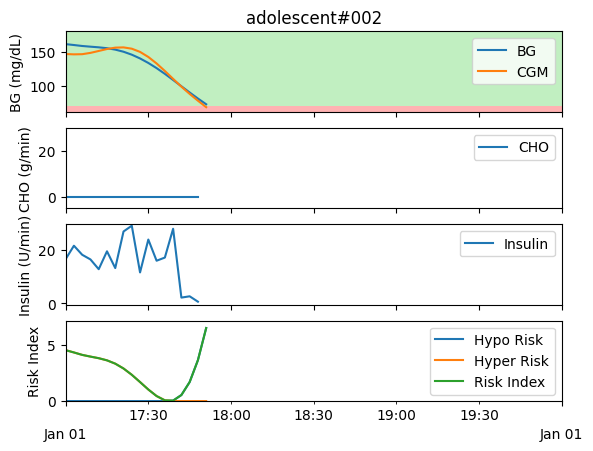

In [ ]:
import gym

# Register gym environment. By specifying kwargs,
# you are able to choose which patient or patients to simulate.
# patient_name must be 'adolescent#001' to 'adolescent#010',
# or 'adult#001' to 'adult#010', or 'child#001' to 'child#010'
# It can also be a list of patient names
# You can also specify a custom scenario or a list of custom scenarios
# If you chose a list of patient names or a list of custom scenarios,
# every time the environment is reset, a random patient and scenario will be
# chosen from the list

from gym.envs.registration import register
from simglucose.simulation.scenario import CustomScenario
from datetime import datetime

start_time = datetime(2018, 1, 1, 0, 0, 0)
meal_scenario = CustomScenario(start_time=start_time, scenario=[(1,20)])


register(
    id='simglucose-adolescent2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002',
            'custom_scenario': meal_scenario}
)

env = gym.make('simglucose-adolescent2-v0')

observation = env.reset()
for t in range(100):
    env.render(mode='human')
    print(observation)
    # Action in the gym environment is a scalar
    # representing the basal insulin, which differs from
    # the regular controller action outside the gym
    # environment (a tuple (basal, bolus)).
    # In the perfect situation, the agent should be able
    # to control the glucose only through basal instead
    # of asking patient to take bolus
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
cgm_data = pd.read_csv('/content/results/CGM DEMO/adolescent#001.csv')

In [ ]:
# Handle missing values
cgm_data['CGM'].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Noise reduction (you can use different filtering techniques)
def apply_smoothing(signal, window_size=3):
    return signal.rolling(window=window_size, min_periods=1).mean()

cgm_data['CGM_smoothed'] = apply_smoothing(cgm_data['CGM'])

# Data alignment (if needed)
# Align data based on a common time index or timestamp

# Print the preprocessed data
print(cgm_data.head())


                  Time      BG         CGM  CHO   insulin  LBGI      HBGI  \
0  2023-08-27 01:00:00  149.02  147.367474  0.0  0.013933   0.0  2.755276   
1  2023-08-27 01:01:00  149.02  148.391441  0.0  0.013933   0.0  2.755276   
2  2023-08-27 01:02:00  149.02  148.829550  0.0  0.013933   0.0  2.755276   
3  2023-08-27 01:03:00  149.02  149.219827  0.0  0.013933   0.0  2.755276   
4  2023-08-27 01:04:00  149.02  149.563338  0.0  0.013933   0.0  2.755276   

       Risk  CGM_smoothed  
0  2.755276    147.367474  
1  2.755276    147.879458  
2  2.755276    148.196155  
3  2.755276    148.813606  
4  2.755276    149.204238  


In [ ]:
X = cgm_data[['CGM', 'CHO', 'insulin']]
y = cgm_data['BG']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import numpy as np

# Print shape and first few rows of X_train_scaled
print("X_train_scaled shape:", X_train_scaled.shape)
print("First few rows of X_train_scaled:")
print(X_train_scaled[:5, :])

# Check for NaN values in X_train_scaled before imputation
nan_indices_before = np.where(np.isnan(X_train_scaled))
print("Number of NaN values in X_train_scaled before imputation:", len(nan_indices_before[0]))


X_train_scaled shape: (48, 3)
First few rows of X_train_scaled:
[[ 6.96731016e-02  0.00000000e+00 -1.73472348e-18]
 [ 1.03939746e+00  0.00000000e+00 -1.73472348e-18]
 [ 3.01072296e-01  0.00000000e+00 -1.73472348e-18]
 [ 3.53214861e-01  0.00000000e+00 -1.73472348e-18]
 [ 2.69195150e-01  0.00000000e+00 -1.73472348e-18]]
Number of NaN values in X_train_scaled before imputation: 2


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
# Handle missing values in the features (X_train_scaled)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)


In [ ]:
# Check for NaN values in X_train_scaled after imputation
nan_indices_after = np.where(np.isnan(X_train_scaled))
print("Number of NaN values in X_train_scaled after imputation:", len(nan_indices_after[0]))




Number of NaN values in X_train_scaled after imputation: 2


In [ ]:
# Drop rows with NaN values
X_train_scaled_cleaned = X_train_scaled[~np.isnan(X_train_scaled).any(axis=1)]
y_train_cleaned = y_train[~np.isnan(X_train_scaled).any(axis=1)]

# Train the model with cleaned data
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train_scaled_cleaned, y_train_cleaned)


RandomForestRegressor(random_state=0)

In [ ]:
# Evaluate the model
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.3189989735792102e-10


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# Create an imputer to fill in missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = [(-score)**0.5 for score in cv_scores]  # Convert negative MSE scores to RMSE

# Calculate mean and standard deviation of RMSE scores
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f'Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean Cross-Validation RMSE: {mean_cv_rmse}')
print(f'Standard Deviation of Cross-Validation RMSE: {std_cv_rmse}')


Cross-Validation RMSE Scores: [8.855058341982022e-06, 8.649732859442709e-06, 6.931951384199269e-06, 1.4778263230375214e-05, 1.3971438726689427e-05]
Mean Cross-Validation RMSE: 1.0637288908537728e-05
Standard Deviation of Cross-Validation RMSE: 3.1343412179891576e-06


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 8.173611630669397e-06
Root Mean Squared Error: 1.1484768058516507e-05


In [ ]:
from sklearn.neural_network import MLPRegressor

# Create an Artificial Neural Network (ANN) model
ann_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=0)

# Train the ANN model
ann_model.fit(X_train_imputed, y_train)

# Make predictions using the trained ANN model
ann_predictions = ann_model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE) for ANN
ann_mae = mean_absolute_error(y_test, ann_predictions)
print(f'Mean Absolute Error (ANN): {ann_mae}')

# Calculate Root Mean Squared Error (RMSE) for ANN
ann_rmse = mean_squared_error(y_test, ann_predictions, squared=False)
print(f'Root Mean Squared Error (ANN): {ann_rmse}')

# Calculate R-squared for ANN
ann_r_squared = ann_model.score(X_test_scaled, y_test)
print(f'R-squared (ANN): {ann_r_squared}')


Mean Absolute Error (ANN): 118.63171939235791
Root Mean Squared Error (ANN): 118.89792345575113
R-squared (ANN): -31200841114525.688


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape the input data for CNN
X_train_cnn = X_train_scaled_cleaned.reshape(X_train_scaled_cleaned.shape[0], X_train_scaled_cleaned.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Create a Convolutional Neural Network (CNN) model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
# Remove or adjust the pool_size as needed
cnn_model.add(MaxPooling1D(pool_size=1))  # You can also remove this line if needed
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train_cleaned, epochs=10, batch_size=32, verbose=1)

# Make predictions using the trained CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)

# Calculate Mean Absolute Error (MAE) for CNN
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
print(f'Mean Absolute Error (CNN): {cnn_mae}')

# Calculate Root Mean Squared Error (RMSE) for CNN
cnn_rmse = mean_squared_error(y_test, cnn_predictions, squared=False)
print(f'Root Mean Squared Error (CNN): {cnn_rmse}')




Epoch 1/10
2/2 [==============================] - 1s 13ms/step - loss: 22184.4043
Epoch 2/10
2/2 [==============================] - 0s 19ms/step - loss: 22173.9277
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 22163.0977
Epoch 4/10
2/2 [==============================] - 0s 11ms/step - loss: 22152.4863
Epoch 5/10
2/2 [==============================] - 0s 12ms/step - loss: 22141.6680
Epoch 6/10
2/2 [==============================] - 0s 12ms/step - loss: 22130.4492
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 22118.5273
Epoch 8/10
2/2 [==============================] - 0s 10ms/step - loss: 22107.1328
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 22094.6094
Epoch 10/10
1/1 [==============================] - 0s 117ms/step
Mean Absolute Error (CNN): 148.47407816613742
Root Mean Squared Error (CNN): 148.47455591690488


In [ ]:
#for population
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import time as dt_time
from datetime import datetime

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

In [ ]:
# specify start_time as the beginning of today
now = datetime.now()
t0 = datetime.combine(now.date(), dt_time(6, 0, 0, 0))
start_time=t0
max_days=15
#start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vpatient_params.csv')
Npat=len(df)

In [ ]:
from simglucose.simulation.scenario_gen import RandomScenario
# Define the path where you want to save the results
output_dir = "/content/drive/MyDrive/Colab Notebooks/CGM FINAL"

# Check if the output directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

N_SAMPLE=288

new_index=0

Vmx=[];
CGM=np.empty((0,288));
CHO=np.empty((0,288));
insulin=np.empty((0,288));
filename=[];

for pat in range(Npat):
    patname=df.iloc[pat]['Name']

    for rep in range(10):
        ##################################################################################################################
        # 1. Setup patient loading its parameters from file
        ##################################################################################################################
        # Create a patient
        patient = T1DPatient.withName(patname)

        ext=1
        count=0
        while(ext>0 & count<10):
            #add random variation to the Vmx value to simulate more patients
            patient._params.Vmx=patient._params.Vmx+0.003*np.random.randn()
            patient_name='{:s}_{:02d}'.format(patname,rep)

            print('Simulating: {:s}, repetition: {:d}'.format(patient_name,count))


            ##################################################################################################################
            # 2. Setup CGM sensor and pump models
            ##################################################################################################################
            # Creat sensor and insulin pump
            sensor = CGMSensor.withName('Dexcom', seed=1)
            pump = InsulinPump.withName('Insulet')

            ##################################################################################################################
            # 3. Setup custom meal pattern
            # custom scenario is a list of tuples (time, meal_size)
            ##################################################################################################################
            #sim_time = timedelta(days=max_days)
            #now = datetime.now()
            #scenario=RandomScenario(start_time=t0, seed=42)

            ##################################################################################################################
            # 3. Setup custom meal pattern
            # custom scenario is a list of tuples (time, meal_size)
            ##################################################################################################################
            prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
            base_t=[7, 10, 12.5, 16, 20, 22]
            base_m = [10, 3, 20, 3, 20, 3]
            sigma_m = [2, 1, 3, 1, 3, 1]
            scen=[]

            for d in range(max_days):
                for i in range(6):
                    pmeal=np.random.uniform()
                    if(pmeal<prob[i]):
                        tm=(base_t[i]+(np.random.uniform()-0.5)*2)*60+d*24*60
                        vm=max(0,base_m[i]+sigma_m[i]*np.random.randn())
                        scen.append((tm,vm))

            scenario = CustomScenario(start_time=start_time, scenario=scen)

            ##################################################################################################################
            # 4. Simulate the CGM measures
            ##################################################################################################################

            env = T1DSimEnv(patient, sensor, pump, scenario)
            env.patient.name=patient_name

            # Create a controller
            controller = BBController()

            # Put them together to create a simulation object
            s2 = SimObj(env, controller, timedelta(days=max_days), animate=False, path=path)
            #print(env.patient.name)
            s2.simulate()
            results2=s2.env.show_history()

            cgm=results2.CGM
            ext=np.sum(cgm<=40)

            if(ext==0):
                for n_days in range(10):

                    patient_name='{:s}_{:02d}_day{:02d}'.format(patname,rep,n_days)

                    start_ind=(n_days+3)*N_SAMPLE
                    stop_ind=(n_days+3+1)*N_SAMPLE

                    Vmx.append(patient._params.Vmx)
                    filename.append(patient_name)
                    # Inside the loop where you save the CSV files
                    savename = os.path.join(output_dir, str(patient_name) + '.csv')
                    day_results.to_csv(savename)
                    CGM=np.vstack((CGM,day_results.CGM))
                    CHO=np.vstack((CHO,day_results.CGM))
                    insulin=np.vstack((insulin,day_results.insulin-day_results.insulin[0]))

                    #plt.plot(results2.CGM)

            count=count+1

            if count>10:
                break


Simulating: adolescent#001_00, repetition: 0
Simulating: adolescent#001_01, repetition: 0
Simulating: adolescent#001_02, repetition: 0
Simulating: adolescent#001_03, repetition: 0
Simulating: adolescent#001_04, repetition: 0
Simulating: adolescent#001_05, repetition: 0
Simulating: adolescent#001_06, repetition: 0
Simulating: adolescent#001_07, repetition: 0
Simulating: adolescent#001_08, repetition: 0
Simulating: adolescent#001_09, repetition: 0
Simulating: adolescent#002_00, repetition: 0
Simulating: adolescent#002_01, repetition: 0
Simulating: adolescent#002_02, repetition: 0
Simulating: adolescent#002_03, repetition: 0
Simulating: adolescent#002_04, repetition: 0
Simulating: adolescent#002_05, repetition: 0
Simulating: adolescent#002_06, repetition: 0
Simulating: adolescent#002_07, repetition: 0
Simulating: adolescent#002_08, repetition: 0
Simulating: adolescent#002_09, repetition: 0
Simulating: adolescent#003_00, repetition: 0
Simulating: adolescent#003_01, repetition: 0
Simulating

KeyboardInterrupt: ignored